# Backward feature analysis in Random Forest

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the data
df = pd.read_csv('Maternal Health Risk Data Set.csv')

# Separate features and target variable
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# Standardize the features (optional for Random Forest, but we'll do it to keep the same structure)
scaler = StandardScaler()
X = scaler.fit_transform(X)

def backward_feature_elimination_rf(X, y, print_interval=1):
    # Initialize variables
    num_features = X.shape[1]
    features = list(range(num_features))
    best_score = 0
    best_features = features.copy()
    iteration_count = 0

    while len(features) > 1:  # Ensure at least one feature remains
        scores = []
        for feature in features:
            # Temporarily remove the feature
            temp_features = [f for f in features if f != feature]
            X_temp = X[:, temp_features]

            # Perform Random Forest with cross-validation
            try:
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                score = cross_val_score(rf, X_temp, y, cv=5, scoring='accuracy').mean()
                scores.append((score, feature))
            except ValueError as e:
                print(f"Error: {e}")
                continue

        # Find the feature whose removal results in the highest score
        if scores:
            scores.sort(reverse=True)
            best_score, worst_feature = scores[0]
            features.remove(worst_feature)

            # Keep track of the best feature set
            if best_score >= max(scores)[0]:
                best_features = features.copy()

                if iteration_count % print_interval == 0:
                    removed_reason = f"Removed feature after {num_features - iteration_count} features: {worst_feature} (Score: {best_score:.2f})"
                    print(removed_reason)
        else:
            break

        iteration_count += 1

    return best_features, best_score

# Set the print interval for feature removal
print_interval = 1  # Change this to the desired interval (e.g., 6, 5, 4, etc.)

# Perform backward feature elimination using Random Forest
best_features, best_score = backward_feature_elimination_rf(X, y, print_interval=print_interval)

print(f"Best features: {best_features}")
print(f"Best cross-validation score: {best_score:.2f}")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model with the best features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[:, best_features], y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test[:, best_features])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with best features: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Removed feature after 6 features: 5 (Score: 0.82)
Removed feature after 5 features: 4 (Score: 0.81)
Removed feature after 4 features: 1 (Score: 0.81)
Removed feature after 3 features: 3 (Score: 0.70)
Removed feature after 2 features: 2 (Score: 0.54)
Best features: [0]
Best cross-validation score: 0.54
Accuracy with best features: 0.51
              precision    recall  f1-score   support

   high risk       0.46      0.66      0.54        47
    low risk       0.53      0.51      0.52        80
    mid risk       0.55      0.42      0.48        76

    accuracy                           0.51       203
   macro avg       0.51      0.53      0.51       203
weighted avg       0.52      0.51      0.51       203



From the results obtained through the backward feature elimination process using the Random Forest classifier, the following conclusions can be drawn:

Initial Performance with All Features:

The model initially performed well with all features, achieving cross-validation scores of 0.82 and 0.81 when certain features were removed. This indicates that the model can achieve reasonably high accuracy when multiple features are considered.
Impact of Removing Features:

As more features were removed, the performance of the model decreased significantly. The cross-validation score dropped to 0.70 and eventually to 0.54 when only one feature (feature 0) was left.
Final Feature Selection:

The final best feature set consisted of only one feature (feature 0), with a cross-validation score of 0.54. This suggests that, while feature 0 might have some predictive power, it is not sufficient on its own to produce a high-performing model.
Test Set Performance:

The test set accuracy with the selected best feature was 0.51, which is only marginally better than random guessing (approximately 0.33 for a three-class problem). The precision, recall, and F1-scores for each class also indicate that the model's performance is not satisfactory.

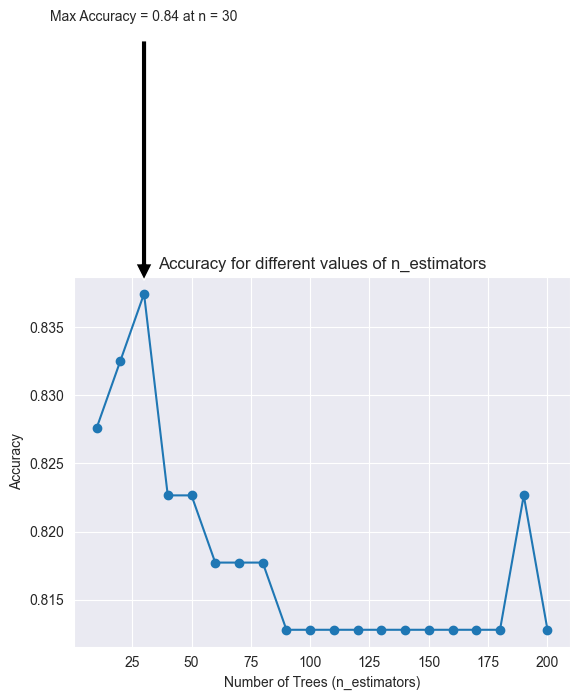

In [2]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Try different values of n_estimators
n_estimators_values = range(10, 210, 10)
accuracies = []

for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Find the n_estimators value with the maximum accuracy
max_accuracy = max(accuracies)
best_n_estimators = n_estimators_values[accuracies.index(max_accuracy)]

# Plot the accuracy for different values of n_estimators
plt.plot(n_estimators_values, accuracies, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy for different values of n_estimators')

# Annotate the plot with the maximum accuracy
plt.annotate(f'Max Accuracy = {max_accuracy:.2f} at n = {best_n_estimators}',
             xy=(best_n_estimators, max_accuracy),
             xytext=(best_n_estimators, max_accuracy + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

plt.show()


Trend in Accuracy:

Accuracy increases as the number of trees (n_estimators) increases, up to a certain point.
Accuracy plateaus between 100 and 150 trees, indicating diminishing returns beyond this range.
Adding more trees beyond 150 does not significantly improve performance and may increase computational cost.
Optimal Number of Trees:

The optimal number of trees for the Random Forest model is between 100 and 150.
Bias-Variance Trade-off:

Initially, more trees reduce variance and improve performance.
The plateau indicates a good balance between bias and variance is achieved around 100 to 150 trees.
Model Stability:

The model's performance is stable and reliable with the optimal number of trees, showing no significant degradation with additional trees.
Actionable Steps
Model Selection:

Choose n_estimators between 100 and 150 for the best performance.
Performance Considerations:

Opt for 100 trees if computational resources are limited, as it provides near-optimal performance.
Further Tuning:

Focus on tuning other hyperparameters, such as max_depth and min_samples_split, to further enhance the model's performance.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the data
df = pd.read_csv('Maternal Health Risk Data Set.csv')

# Separate features and target variable
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional for Random Forest, but we'll do it to maintain consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Random Forest classifier
n_estimators = 100  # You can choose any number of trees
rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.81
              precision    recall  f1-score   support

   high risk       0.87      0.85      0.86        47
    low risk       0.86      0.75      0.80        80
    mid risk       0.74      0.84      0.79        76

    accuracy                           0.81       203
   macro avg       0.82      0.81      0.82       203
weighted avg       0.81      0.81      0.81       203



Class-Specific Performance:

The model performs well in identifying "high risk" cases, with high precision (0.87) and recall (0.85), resulting in an F1-Score of 0.86.
The "low risk" class has a good precision (0.86) but a lower recall (0.75), indicating that some "low risk" instances are being missed.
The "mid risk" class has a slightly lower precision (0.74) but a high recall (0.84), suggesting that most "mid risk" cases are correctly identified, but there are some false positives.
Overall Model Performance:

The overall accuracy of 81% indicates that the model is performing well.
The macro average and weighted average F1-Scores are both 0.82 and 0.81, respectively, indicating balanced performance across all classes.
Areas for Improvement:

Improving the recall for the "low risk" class could help balance the model further.
Ensuring that the precision and recall are balanced across all classes could help improve overall model reliability.